# UniNa - Data Mining 20/21 - MiniContest n3
## Parasite Eggs Identification
https://www.kaggle.com/c/unina-data-mining-2021-minicontest-n3/overview

# 1. Introduction
This notebook shows the solution proposed for the third Mini-Contest of the Data Mining course of University of Naples Federico II.

The contest aims at the detection of parasite eggs in microscopic images.
It is a **bynary classification** problem, since the model must predict one of the following classes:
- *uovo* (egg): meaning that the image contains a parasite egg;
- *empty*, meaning that the image does not contain any egg.

The prediction model has to be able to correctly predict the presence of an egg for each image in the test set. The performance measure to maximize is the **accuracy** of the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1.1. Import relevant modules

In [2]:
# Data Analysis
import pandas as pd

# Data Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix

# Utilities
import numpy as np
import time
import os
import shutil
import copy
import random
from PIL import Image

In [3]:
%config InlineBackend.figure_format = 'retina'

## 1.2. Read the dataset


In [4]:
!cp drive/My\ Drive/Colab\ Notebooks/DM\ -\ Collab/Mini\ Contest\ 3/dataset/test.rar /content/
!cp drive/My\ Drive/Colab\ Notebooks/DM\ -\ Collab/Mini\ Contest\ 3/dataset/train.rar /content/

!unrar x test.rar dataset/ 
!unrar x train.rar dataset/ 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from test.rar

Creating    dataset                                                   OK
Creating    dataset/test                                              OK
Extracting  dataset/test/2_1.png                                           0%  OK 
Extracting  dataset/test/2_10.png                                          0%  OK 
Extracting  dataset/test/2_100.png                                         0%  OK 
Extracting  dataset/test/2_101.png                                         0%  OK 
Extracting  dataset/test/2_102.png                                         0%  OK 
Extracting  dataset/test/2_103.png                                         0%  OK 
Extracting  dataset/test/2_104.png                                         1%  OK 
Extracting  dataset/test/2_105.png                                         1%  OK 
Extracting  dataset/tes

### 1.2.1. Training set

In [5]:
train_empty = os.listdir('dataset/train/empty')
train_egg = os.listdir('dataset/train/uovo')

print('Training set size:', len(train_empty)+len(train_egg))
print('Empty images:', len(train_empty))
print('Egg images:', len(train_egg))

Training set size: 1722
Empty images: 867
Egg images: 855


To simplify the data analysis stage, we build a dataframe which contains some useful information extracted from the path of the images.

As a matter of fact, each image is characterized by the following attributes:
- **path**: path where the image file is located.
- **acquisition**: acquisition in which the image was collected.
- **name**: name of the image. 
- **direction**: orientation of the image. The same image may be present in the dataset with different orientation. This was made to balanced the class of the data, since the egg images were less in number. A better explanation about direction can be found [here](https://www.kaggle.com/c/unina-data-mining-2021-minicontest-n3/data).
- **label**: label of the image.

In [6]:
df_train = pd.DataFrame(columns=['path', 'acquisition', 'name', 'direction', 'label'])

In [7]:
label = 'empty'

for imm in train_empty:
  path = '/content/dataset/train/empty/' + imm

  if imm.startswith('Acquisizione'):
    acquisition, name1, name2, name3, direction = imm.split(sep='_')  
    name = name1 + '_' + name2 + '_' + name3
    direction = direction.split(sep='.')[0]

  row = {'path':[path], 'acquisition':[acquisition], 'name':[name], 'direction':[direction], 'label':[label]}
  df_train = df_train.append(pd.DataFrame(row))

In [8]:
label = 'egg'

for imm in train_egg:
  path = '/content/dataset/train/uovo/' + imm

  if imm.startswith('Acquisizione'):
    acquisition, name1, name2, name3, name4, direction = imm.split(sep='_')  
    name = name1 + '_' + name2 + '_' + name3  + '_' + name4
    direction = direction.split(sep='.')[0]

  if imm.startswith('KFM'):
    acquisition1, acquisition2, name1, name2, direction = imm.split(sep='_') 
    acquisition = acquisition1 + '_' + acquisition2
    name = name1 + '_' + name2
    direction = direction.split(sep='.')[0]

  if imm.startswith('Qualita'):
    acquisition, name1, name2, direction = imm.split(sep='_')  
    name = name1 + '_' + name2
    direction = direction.split(sep='.')[0]

  row = {'path':[path], 'acquisition':[acquisition], 'name':[name], 'direction':[direction], 'label':[label]}
  df_train = df_train.append(pd.DataFrame(row))

### 1.2.2. Test set

In [9]:
test = os.listdir('dataset/test')

print('Test set size:', len(test))

Test set size: 738


# 2. Exploratory Data Analysis
First of all, we want to gain a better knowledge of the data.

In [10]:
df_train.head()

,path,acquisition,name,direction,label
0,/content/dataset/train/empty/Acquisizione5_mic...,Acquisizione5,micro_15_00,central,empty
0,/content/dataset/train/empty/Acquisizione6_mic...,Acquisizione6,micro_07_10,central,empty
0,/content/dataset/train/empty/Acquisizione7_mic...,Acquisizione7,micro_13_02,central,empty
0,/content/dataset/train/empty/Acquisizione5_mic...,Acquisizione5,micro_06_08,central,empty
0,/content/dataset/train/empty/Acquisizione1_mic...,Acquisizione1,micro_01_05,central,empty


In [11]:
df_train.shape

(1722, 5)

In [12]:
df_train.describe(include='all')

,path,acquisition,name,direction,label
count,1722,1722,1722,1722,1722
unique,1722,7,373,5,2
top,/content/dataset/train/uovo/Acquisizione6_micr...,Acquisizione3,micro_00_03_1,central,empty
freq,1,484,15,1038,867


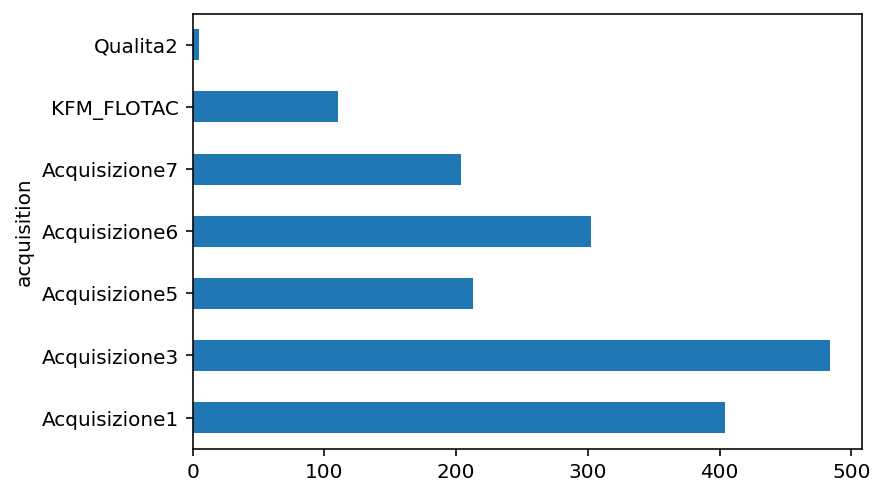

In [13]:
df_train.groupby('acquisition').path.count().plot.barh()
plt.show()

Different acquisitions have different size.

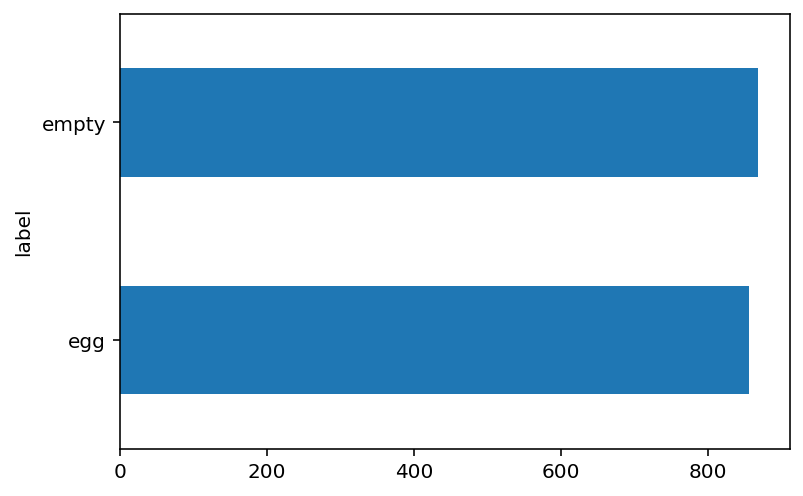

In [14]:
df_train.groupby('label').path.count().plot.barh()
plt.show()

Thanks to the "direction trick" the training set is balanced, in term of class.

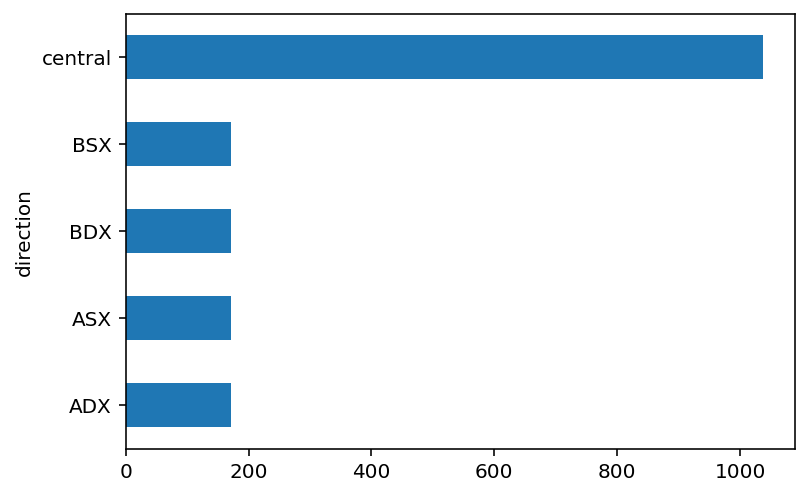

In [15]:
df_train.groupby('direction').path.count().plot.barh()
plt.show()

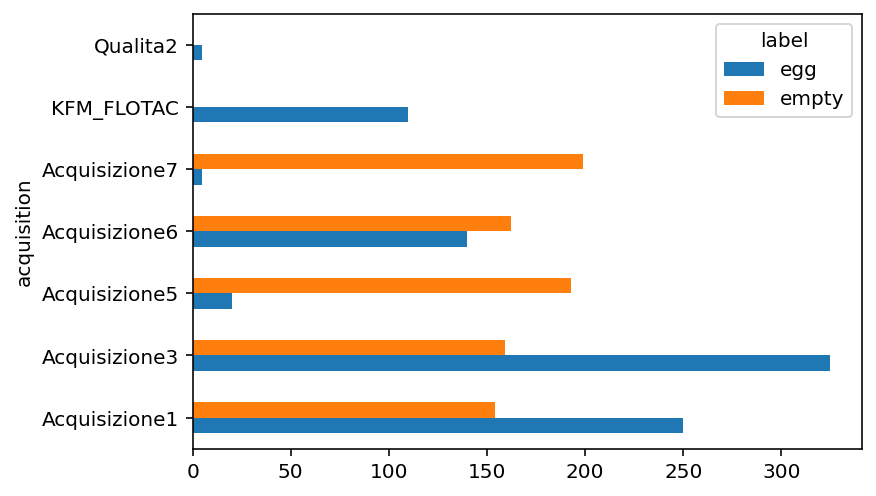

In [16]:
df_train.groupby(['label', 'acquisition']).path.count().unstack(0).plot.barh()
plt.show()

In the figure above we can see the class distribution for different acquisition. We will use this information to split properly the training set in training, validation and test set.

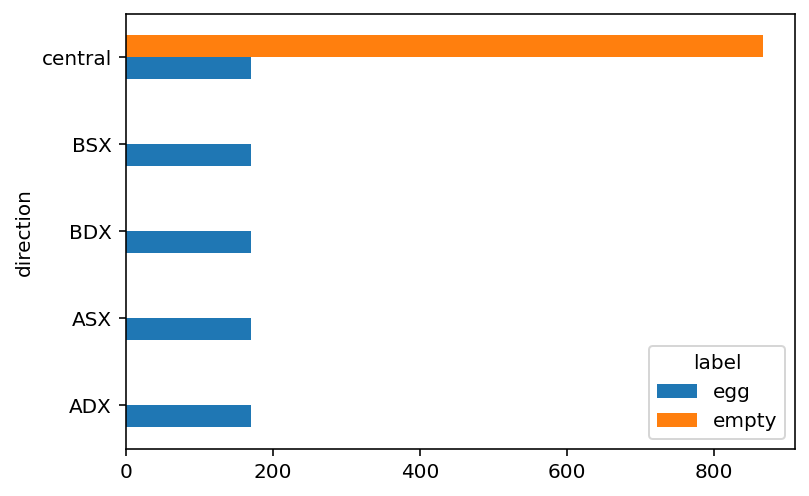

In [17]:
df_train.groupby(['label', 'direction']).path.count().unstack(0).plot.barh()
plt.show()

The figure above confirms that different directions are used only for egg images. 

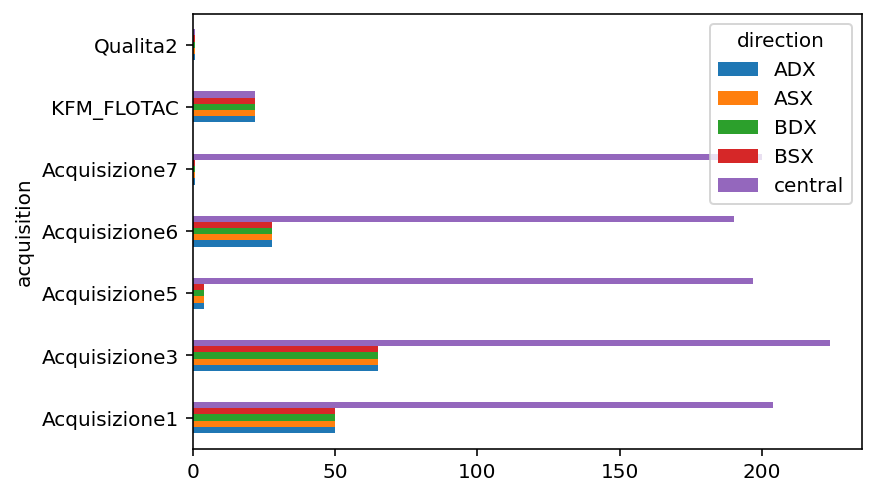

In [18]:
df_train.groupby(['direction', 'acquisition']).path.count().unstack(0).plot.barh()
plt.show()

The figure above guarantees that different directions of the same image refer to the same acquisition. 

# 3. Data Preparation
Before moving forward we need to prepare our data so that a model can use it for both training and prediction.

The basic idea is to apply a **stratified holdout** techinique, dividing the training set in 3 different datasets:
- *training set* (60%), which will be used to train the model;
- *validation set* (20%), which will be used to optimize the hyperparameters of the model;
- *test set* (20%), which will be used to evaluate model's performance and to perform model selection.

Stratification ensure that the class are balanced in all the subsets. Moreover, when splitting the dataset, we shold ensure that images from the same acquisition are not used for training and validation (or training and testing). In other words, training, validation and test set should be made up of different acquisitions to be as independent as possible.

## 3.1. Hyperparameters tuning
Now we prepare data for the hyperparameters optimization stage.


In [19]:
df_train_ = df_train.loc[(df_train.acquisition=='Acquisizione1') |
             (df_train.acquisition=='Acquisizione3') |
             (df_train.acquisition=='Acquisizione7')]
df_train_.shape

(1092, 5)

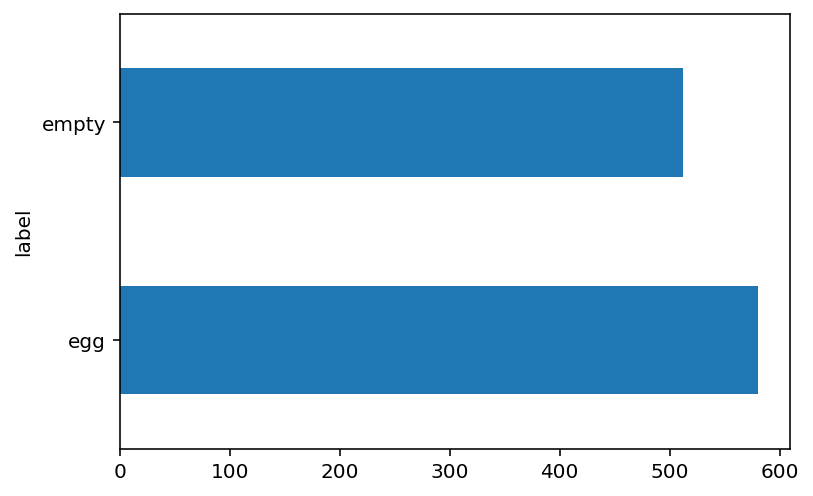

In [20]:
df_train_.groupby('label').path.count().plot.barh()
plt.show()

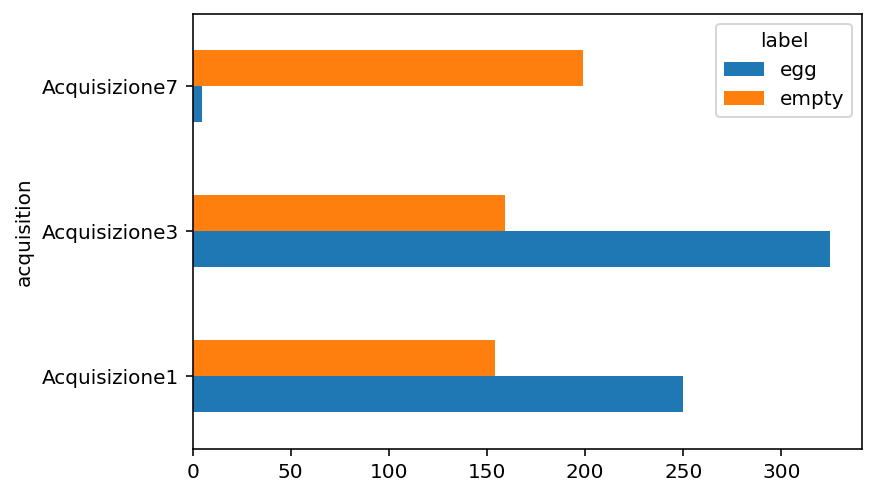

In [21]:
df_train_.groupby(['label', 'acquisition']).path.count().unstack(0).plot.barh()
plt.show()

In [22]:
df_val = df_train.loc[(df_train.acquisition=='Acquisizione5') |
             (df_train.acquisition=='Qualita2') |
             (df_train.acquisition=='KFM_FLOTAC')]
df_val.shape

(328, 5)

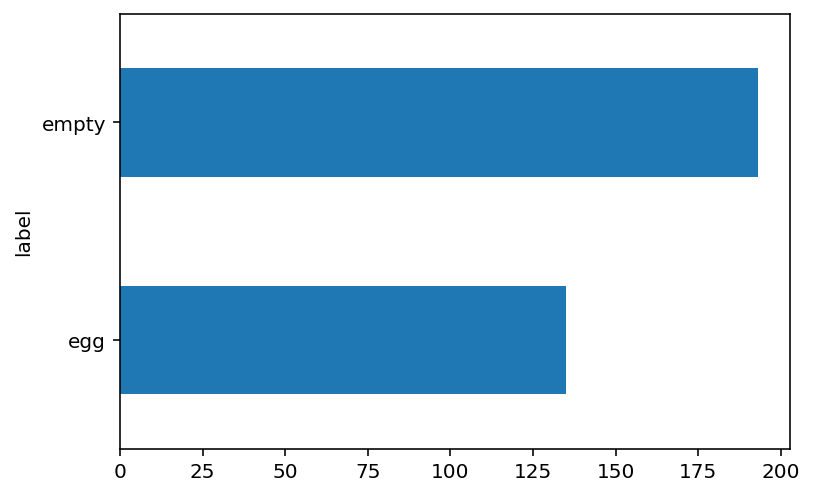

In [23]:
df_val.groupby('label').path.count().plot.barh()
plt.show()

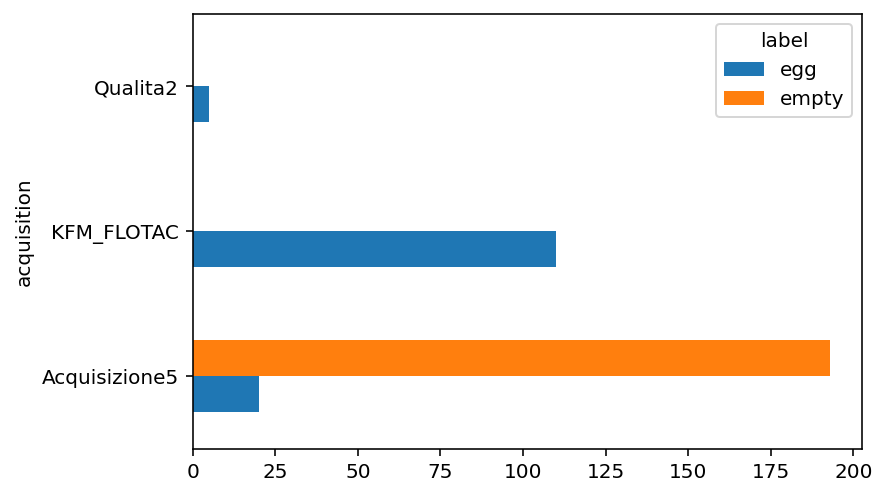

In [24]:
df_val.groupby(['label', 'acquisition']).path.count().unstack(0).plot.barh()
plt.show()

In [25]:
print('Training set:', df_train_.shape[0]/df_train.shape[0])
print('Validation set:', df_val.shape[0]/df_train.shape[0])

Training set: 0.6341463414634146
Validation set: 0.19047619047619047


In [26]:
!mkdir /content/dataset/hyperparam

!mkdir /content/dataset/hyperparam/train
!mkdir /content/dataset/hyperparam/train/empty
!mkdir /content/dataset/hyperparam/train/egg

!mkdir /content/dataset/hyperparam/val
!mkdir /content/dataset/hyperparam/val/empty
!mkdir /content/dataset/hyperparam/val/egg

In [27]:
for index, row in df_train_.iterrows():
  if(row.label=='egg'):
    shutil.copy2(row.path, '/content/dataset/hyperparam/train/egg')
  if(row.label=='empty'):
    shutil.copy2(row.path, '/content/dataset/hyperparam/train/empty')

for index, row in df_val.iterrows():
  if(row.label=='egg'):
    shutil.copy2(row.path, '/content/dataset/hyperparam/val/egg')
  if(row.label=='empty'):
    shutil.copy2(row.path, '/content/dataset/hyperparam/val/empty')

## 3.1. Model selection
Now we prepare data for the model selection stage. We will use the union of training and validation set to train the model and test set to evaluate his performance. 

In [28]:
df_train_val = df_train_.append(df_val)
df_train_val.shape

(1420, 5)

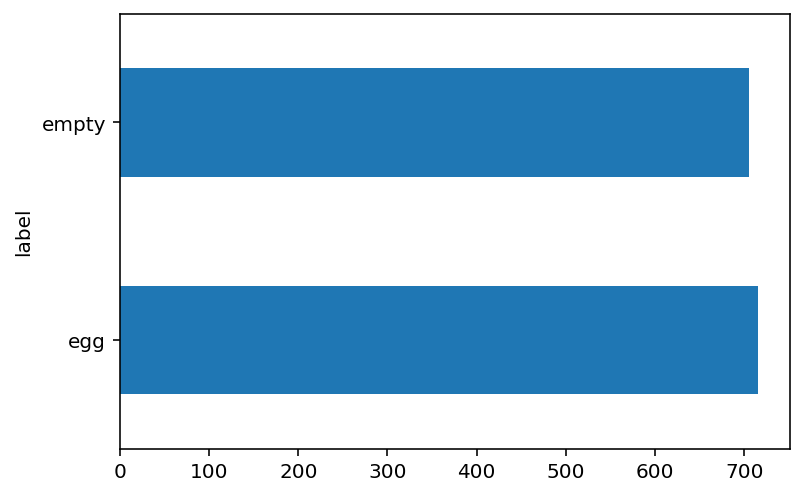

In [29]:
df_train_val.groupby('label').path.count().plot.barh()
plt.show()

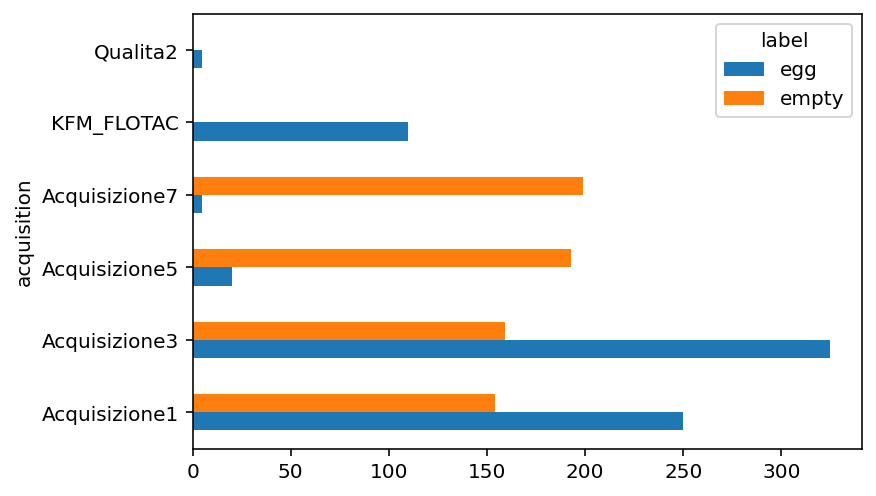

In [30]:
df_train_val.groupby(['label', 'acquisition']).path.count().unstack(0).plot.barh()
plt.show()

In [31]:
df_test = df_train.loc[df_train.acquisition=='Acquisizione6']
df_test.shape

(302, 5)

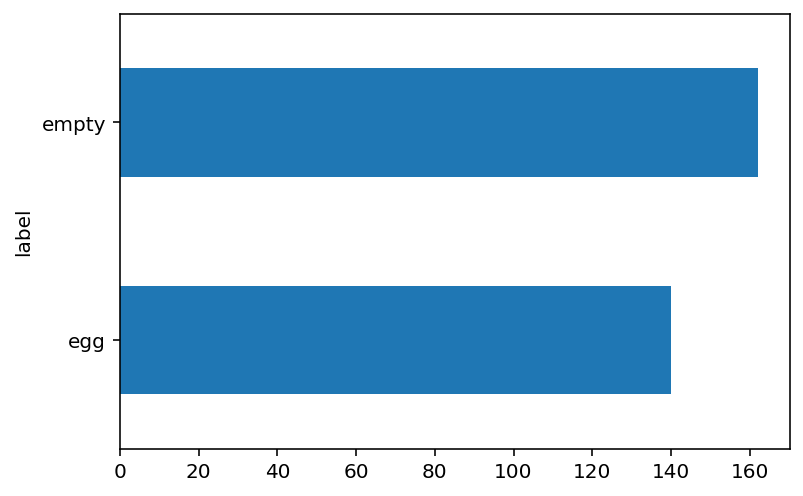

In [32]:
df_test.groupby('label').path.count().plot.barh()
plt.show()

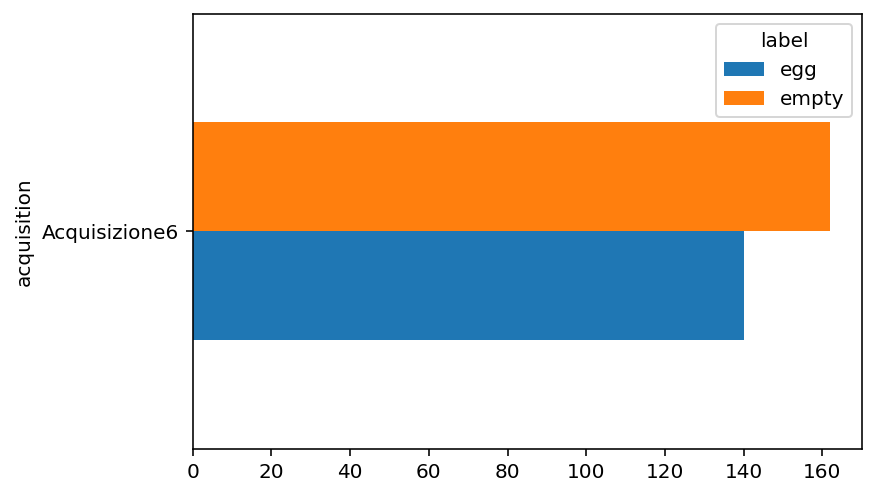

In [33]:
df_test.groupby(['label', 'acquisition']).path.count().unstack(0).plot.barh()
plt.savefig('/content/test_label_acquisition.png', bbox_inches='tight')
plt.show()

In [34]:
print('Training set:', df_train_val.shape[0]/df_train.shape[0])
print('Test set:', df_test.shape[0]/df_train.shape[0])

Training set: 0.8246225319396051
Test set: 0.1753774680603949


In [35]:
!mkdir /content/dataset/modelselect

!mkdir /content/dataset/modelselect/train
!mkdir /content/dataset/modelselect/train/empty
!mkdir /content/dataset/modelselect/train/egg

!mkdir /content/dataset/modelselect/test
!mkdir /content/dataset/modelselect/test/empty
!mkdir /content/dataset/modelselect/test/egg

In [36]:
for index, row in df_train_val.iterrows():
  if(row.label=='egg'):
    shutil.copy2(row.path, '/content/dataset/modelselect/train/egg')
  if(row.label=='empty'):
    shutil.copy2(row.path, '/content/dataset/modelselect/train/empty')

for index, row in df_test.iterrows():
  if(row.label=='egg'):
    shutil.copy2(row.path, '/content/dataset/modelselect/test/egg')
  if(row.label=='empty'):
    shutil.copy2(row.path, '/content/dataset/modelselect/test/empty')

# 4. Modelling
Completed the previous stage, we can start seeking the best model for our classification problem.

In [37]:
# deterministic execution
torch.manual_seed(0)
# torch.set_deterministic(True)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True 

np.random.seed(0)

## 4.1. Helper function
Let's define some functions that will be used later in this section.

### 4.1.1. Training and validation
Function *train_val_model* is used to train the model on the training set and to evaluate his performance on an independent validation set. Basically it performs the following steps:
- for each epoch
  -  train phase
    - set model in training mode
    - for each batch
      - reset the gradient
      - forward (predition and loss)
      - backward (optimization step)
      - update loss and accuracy
    - compute epoch loss and accuracy
  - validation phase
    - set model in validation mode
    - for each batch
      - reset the gradient
      - forward (predition and loss)
      - update loss and accuracy
    - compute epoch loss and accuracy
    - save the current best model

In [38]:
def train_val_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = [] 

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.0
    best_epoch = -1   

    # for each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model in training mode
            else:
                model.eval()  # set model in validation mode

            running_loss = 0.0
            running_corrects = 0

            # for each batch
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # reset the gradient

                with torch.set_grad_enabled(phase == 'train'):
                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    
                    if phase == 'train':
                        # backward
                        loss.backward()
                        optimizer.step()  # optimization step

                # update loss and accuracy
                running_loss += loss.item() * inputs.size(0) 
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                scheduler.step()

            # compute epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            if phase == 'val' and ((epoch_acc > best_acc) or (epoch_acc == best_acc and epoch_loss < best_loss)):
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best epoch: {:d}'.format(best_epoch))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_loss, train_acc, val_loss, val_acc

### 4.1.2. Training
Function *train_model* is used to train the model on the union of training and validation set. Basically it performs the same steps of the previous function, except for the validation phase which is not execute.

In [39]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_loss = []
    train_acc = []

    # for each epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train() # set model in training mode
            else:
                model.eval()  # set model in validation mode

            running_loss = 0.0
            running_corrects = 0

            # for each batch
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() # reset the gradient

                with torch.set_grad_enabled(phase == 'train'):
                    # forward
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        # backward
                        loss.backward()
                        optimizer.step()  # optimization step

                # update loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train' and scheduler:
                scheduler.step()

            # compute epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model, train_loss, train_acc

### 4.1.3. Utilities
Function *set_parameter_requires_grad* is used to define the parameters of the network that has to be trained. It takes in input the model and a parameter *mode*, which may be:
- *feature_extraction*: train only layers of the classifier (fully-connected layers);
- *fine_tuning*: train all the layers of the network;
- *mixed*: train the layers of the classifier and the last convolutional layer.

In [40]:
def set_parameter_requires_grad(model, mode, n=0, m=0):
    if mode == 'feature_extraction':
        print('Feature extraction: training classifier')
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
    elif mode == 'fine_tuning':
        print('Fine tuning: training all the layers')
        for param in model.parameters():
            param.requires_grad = True
    elif mode == 'mixed' and n!=0 and m!=0:
        print('Mixed: training classifier and last convolutional layer')
        for param in model.parameters():
            param.requires_grad = False
        for i in range(n, m+1):
            for param in model.features[i].parameters():
                param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        print("Invalid mode, exiting...")

Function *initialize_model* is used to initialize the network. It is possible to choose among *AlexNet*, *VGG11* and *GoogLeNet*. It takes in input the mode, used in the previous function, and a parameter *use_pretrained*, which specifies if the network should be pretrained or not.

In [41]:
def initialize_model(model_name, num_classes, mode, use_pretrained=True):
    model = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model, mode, n=10, m=12)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg11":
        """ VGG11_bn
        """
        model = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model, mode, n=25, m=28)
        num_ftrs = model.classifier[6].in_features
        model.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    
    elif model_name == "googlenet":
        """ GoogLeNet 
        """
        model = models.googlenet(pretrained=use_pretrained)
        set_parameter_requires_grad(model, mode)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model, input_size

## 4.2. Hyperparameters tuning
The first step of the modelling stage is hyperparameters tuning, which is the process of choosing a set of optimal hyperparameters of a model. Given a certain model, we will train it on training data and evaluate his performance on validation data. We will repeat this procedure looking at model's performance and changing the hyperparameters accordingly. The whole process will be repeated for different models.

For each model, we will consider the following hyperparameters:
- *mode*: learning strategy (feature extraction, fine tuning or a "mixed" approach);
- *batch_size*: size of a batch;
- *num_epochs*: number of epochs to perform;
- *loss function*: function to minimize during the training;
- *optimizer*: optimization algorithm used to train the model;
  - *learning_rate*: learning rate used by the optimization algorithm;
  - *weight_decay*: L2 penalty;
  - *learning rate scheduler*: scheduler used during the optimization algorithm, responsible for decreasing learning rate during the optimization;
    - *gamma*: decay's factor.
    - *step_size*: period of learning rate decay.

### 4.2.1. AlexNet

Initialize the model, specifying the name and the number of classes of our problem.


In [87]:
model_name = 'alexnet'
num_classes = 2

mode = 'feature_extraction' # hyperparameter

model, input_size = initialize_model(model_name, num_classes, mode, use_pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Feature extraction: training classifier
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_featu

Define the hyperparameters.

In [88]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

batch_size = 32
num_epochs = 100

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
learning_rate = 0.00001
weight_decay = 0
optimizer = optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
gamma = 1
step_size = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
	 classifier.4.weight
	 classifier.4.bias
	 classifier.6.weight
	 classifier.6.bias


Load training and validation data.

In [89]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(90),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ]),
                   'val':transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                             ])
                   }

data_dir = '/content/dataset/hyperparam'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1092, 'val': 328}
['egg', 'empty']


Set GPU as device, if available. 

In [90]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


Train the model and evaluate his performans on validation set.

In [91]:
model, train_loss, train_acc, val_loss, val_acc = train_val_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

Epoch 0/99
----------
train Loss: 0.5770 Acc: 0.7134
val Loss: 0.3458 Acc: 0.9604

Epoch 1/99
----------
train Loss: 0.4217 Acc: 0.8425
val Loss: 0.2514 Acc: 0.9695

Epoch 2/99
----------
train Loss: 0.3651 Acc: 0.8755
val Loss: 0.1812 Acc: 0.9665

Epoch 3/99
----------
train Loss: 0.3216 Acc: 0.8800
val Loss: 0.1563 Acc: 0.9665

Epoch 4/99
----------
train Loss: 0.2927 Acc: 0.8782
val Loss: 0.1405 Acc: 0.9665

Epoch 5/99
----------
train Loss: 0.2808 Acc: 0.8855
val Loss: 0.1226 Acc: 0.9665

Epoch 6/99
----------
train Loss: 0.2717 Acc: 0.8965
val Loss: 0.1218 Acc: 0.9634

Epoch 7/99
----------
train Loss: 0.2589 Acc: 0.9057
val Loss: 0.1179 Acc: 0.9695

Epoch 8/99
----------
train Loss: 0.2357 Acc: 0.9048
val Loss: 0.1108 Acc: 0.9634

Epoch 9/99
----------
train Loss: 0.2385 Acc: 0.9048
val Loss: 0.1117 Acc: 0.9604

Epoch 10/99
----------
train Loss: 0.2324 Acc: 0.9130
val Loss: 0.1130 Acc: 0.9634

Epoch 11/99
----------
train Loss: 0.2279 Acc: 0.9176
val Loss: 0.1126 Acc: 0.9634

Ep

Use accuracy and loss plots to optimize the hyperparameters of the model.

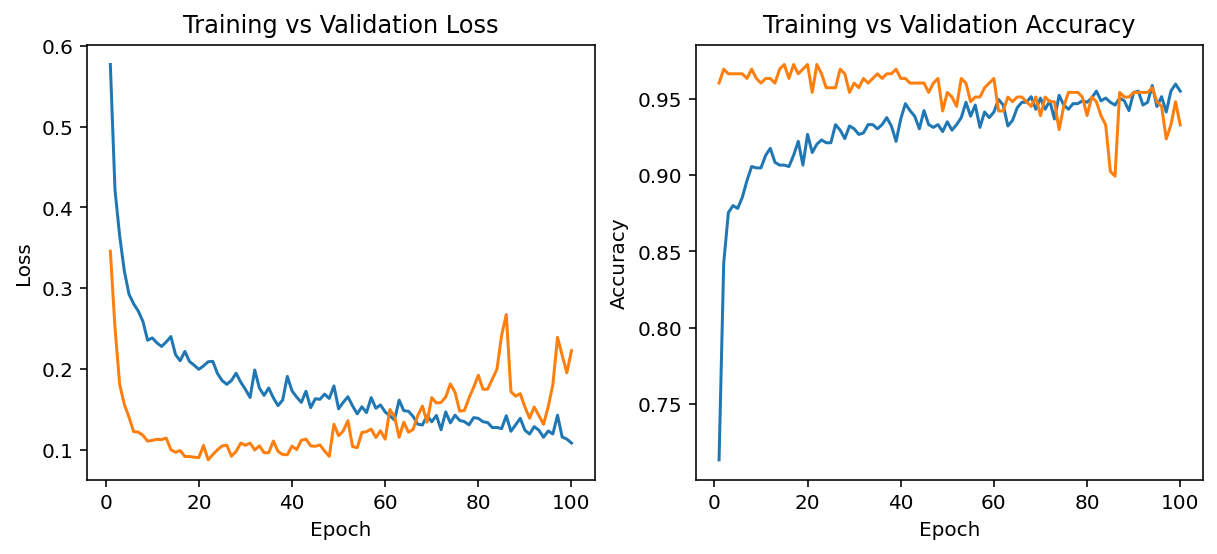

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Training Loss')
axs[0].plot(list(range(1, len(val_loss)+1)), val_loss, label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(list(range(1,len(train_acc)+1)), train_acc, label='Training Loss')
axs[1].plot(list(range(1, len(val_acc)+1)), val_acc, label='Validation Loss')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')

plt.show()

Save the best hyperparameters found for AlexNet.

In [93]:
model_name = 'alexnet'
num_classes = 2

alexnet_mode = 'feature_extraction'

alexnet, input_size = initialize_model(model_name, num_classes, alexnet_mode, use_pretrained=True)

alexnet_params = []
for name, param in alexnet.named_parameters():
    if param.requires_grad == True:
        alexnet_params.append(param)

alexnet_batch_size = 32
alexnet_num_epochs = 30

alexnet_criterion = nn.CrossEntropyLoss()

alexnet_learning_rate = 0.00001
alexnet_weight_decay = 0
alexnet_optimizer = optim.Adam(alexnet_params, lr=alexnet_learning_rate, weight_decay=alexnet_weight_decay)

alexnet_gamma = 1
alexnet_step_size = 10
alexnet_scheduler = lr_scheduler.StepLR(alexnet_optimizer, step_size=alexnet_step_size, gamma=alexnet_gamma)

Feature extraction: training classifier


### 4.2.2. VGG11

In [42]:
model_name = 'vgg11'
num_classes = 2

mode = 'mixed' # hyperparameter

model, input_size = initialize_model(model_name, num_classes, mode, use_pretrained=True)
print(model)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



Mixed: training classifier and last convolutional layer
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [43]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

batch_size = 32
num_epochs = 100

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
learning_rate = 0.00001
weight_decay = 0
optimizer = optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
gamma = 1
step_size = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Params to learn:
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


In [44]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ]),
                   'val':transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                             ])
                   }

data_dir = '/content/dataset/hyperparam'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1092, 'val': 328}
['egg', 'empty']


In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [46]:
model, train_loss, train_acc, val_loss, val_acc = train_val_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

Epoch 0/99
----------
train Loss: 0.5464 Acc: 0.7573
val Loss: 0.2765 Acc: 0.9726

Epoch 1/99
----------
train Loss: 0.3320 Acc: 0.8938
val Loss: 0.1143 Acc: 0.9695

Epoch 2/99
----------
train Loss: 0.2273 Acc: 0.9249
val Loss: 0.0900 Acc: 0.9665

Epoch 3/99
----------
train Loss: 0.1752 Acc: 0.9341
val Loss: 0.0724 Acc: 0.9726

Epoch 4/99
----------
train Loss: 0.1319 Acc: 0.9560
val Loss: 0.0606 Acc: 0.9756

Epoch 5/99
----------
train Loss: 0.0996 Acc: 0.9707
val Loss: 0.0531 Acc: 0.9756

Epoch 6/99
----------
train Loss: 0.0768 Acc: 0.9817
val Loss: 0.0410 Acc: 0.9756

Epoch 7/99
----------
train Loss: 0.0730 Acc: 0.9771
val Loss: 0.0308 Acc: 0.9878

Epoch 8/99
----------
train Loss: 0.0649 Acc: 0.9863
val Loss: 0.0350 Acc: 0.9848

Epoch 9/99
----------
train Loss: 0.0421 Acc: 0.9908
val Loss: 0.0305 Acc: 0.9939

Epoch 10/99
----------
train Loss: 0.0524 Acc: 0.9799
val Loss: 0.0170 Acc: 1.0000

Epoch 11/99
----------
train Loss: 0.0334 Acc: 0.9927
val Loss: 0.0205 Acc: 0.9970

Ep

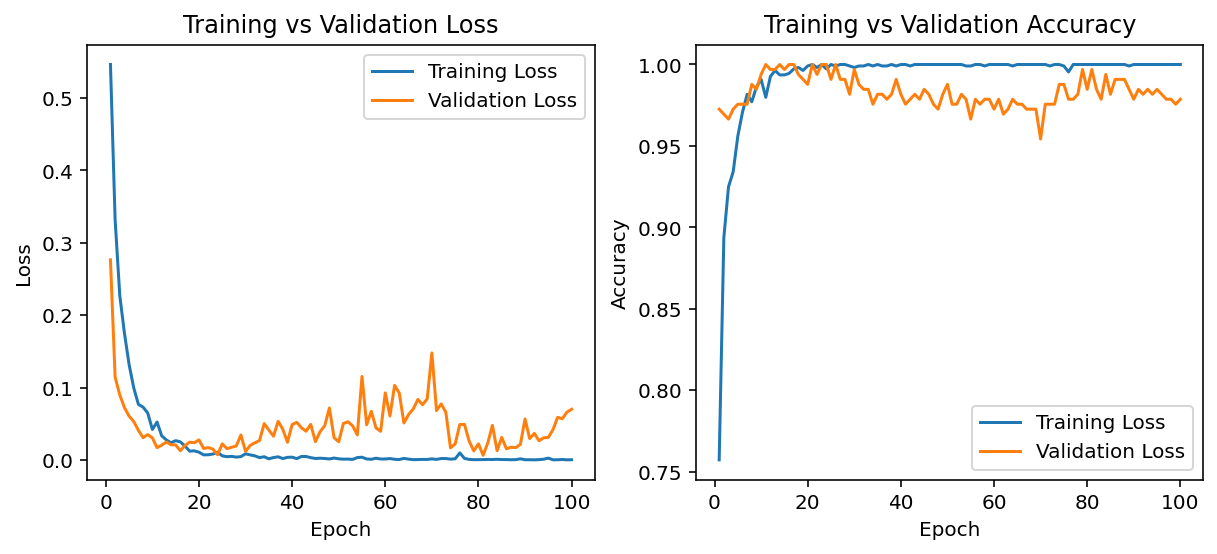

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Training Loss')
axs[0].plot(list(range(1, len(val_loss)+1)), val_loss, label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(train_acc)+1)), train_acc, label='Training Loss')
axs[1].plot(list(range(1, len(val_acc)+1)), val_acc, label='Validation Loss')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
model_name = 'vgg11'
num_classes = 2

vgg11_mode = 'mixed'

vgg11, input_size = initialize_model(model_name, num_classes, vgg11_mode, use_pretrained=True)

vgg11_params = []
for name, param in vgg11.named_parameters():
    if param.requires_grad == True:
        vgg11_params.append(param)

vgg11_batch_size = 32
vgg11_num_epochs = 30

vgg11_criterion = nn.CrossEntropyLoss()

vgg11_learning_rate = 0.00001
vgg11_weight_decay = 0
vgg11_optimizer = optim.Adam(vgg11_params, lr=vgg11_learning_rate, weight_decay=vgg11_weight_decay)

vgg11_gamma = 1
vgg11_step_size = 10
vgg11_scheduler = lr_scheduler.StepLR(vgg11_optimizer, step_size=vgg11_step_size, gamma=vgg11_gamma)

Mixed: training classifier and last convolutional layer


### 4.2.3. GoogLeNet

In [57]:
model_name = 'googlenet'
num_classes = 2

mode = 'fine_tuning' # hyperparameter

model, input_size = initialize_model(model_name, num_classes, mode, use_pretrained=True)
print(model)

Fine tuning: training all the layers
GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.

In [58]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

batch_size = 32
num_epochs = 100

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
learning_rate = 0.00001
weight_decay = 0
optimizer = optim.Adam(params_to_update, lr=learning_rate, weight_decay=weight_decay)

# scheduler
gamma = 1
step_size = 10
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

Params to learn:
	 conv1.conv.weight
	 conv1.bn.weight
	 conv1.bn.bias
	 conv2.conv.weight
	 conv2.bn.weight
	 conv2.bn.bias
	 conv3.conv.weight
	 conv3.bn.weight
	 conv3.bn.bias
	 inception3a.branch1.conv.weight
	 inception3a.branch1.bn.weight
	 inception3a.branch1.bn.bias
	 inception3a.branch2.0.conv.weight
	 inception3a.branch2.0.bn.weight
	 inception3a.branch2.0.bn.bias
	 inception3a.branch2.1.conv.weight
	 inception3a.branch2.1.bn.weight
	 inception3a.branch2.1.bn.bias
	 inception3a.branch3.0.conv.weight
	 inception3a.branch3.0.bn.weight
	 inception3a.branch3.0.bn.bias
	 inception3a.branch3.1.conv.weight
	 inception3a.branch3.1.bn.weight
	 inception3a.branch3.1.bn.bias
	 inception3a.branch4.1.conv.weight
	 inception3a.branch4.1.bn.weight
	 inception3a.branch4.1.bn.bias
	 inception3b.branch1.conv.weight
	 inception3b.branch1.bn.weight
	 inception3b.branch1.bn.bias
	 inception3b.branch2.0.conv.weight
	 inception3b.branch2.0.bn.weight
	 inception3b.branch2.0.bn.bias
	 inception3b.bra

In [59]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ]),
                   'val':transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])
                                             ])
                   }

data_dir = '/content/dataset/hyperparam'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1092, 'val': 328}
['egg', 'empty']


In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda:0


In [61]:
model, train_loss, train_acc, val_loss, val_acc = train_val_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs)

Epoch 0/99
----------
train Loss: 0.6043 Acc: 0.7326
val Loss: 0.5158 Acc: 0.9116

Epoch 1/99
----------
train Loss: 0.4607 Acc: 0.8709
val Loss: 0.3377 Acc: 0.9726

Epoch 2/99
----------
train Loss: 0.3724 Acc: 0.8846
val Loss: 0.2414 Acc: 0.9848

Epoch 3/99
----------
train Loss: 0.2995 Acc: 0.9203
val Loss: 0.1710 Acc: 0.9878

Epoch 4/99
----------
train Loss: 0.2441 Acc: 0.9423
val Loss: 0.1427 Acc: 0.9878

Epoch 5/99
----------
train Loss: 0.2100 Acc: 0.9396
val Loss: 0.1186 Acc: 0.9878

Epoch 6/99
----------
train Loss: 0.1641 Acc: 0.9661
val Loss: 0.1097 Acc: 0.9878

Epoch 7/99
----------
train Loss: 0.1463 Acc: 0.9670
val Loss: 0.0948 Acc: 0.9878

Epoch 8/99
----------
train Loss: 0.1199 Acc: 0.9808
val Loss: 0.0928 Acc: 0.9909

Epoch 9/99
----------
train Loss: 0.1158 Acc: 0.9734
val Loss: 0.0733 Acc: 0.9909

Epoch 10/99
----------
train Loss: 0.0923 Acc: 0.9908
val Loss: 0.0795 Acc: 0.9878

Epoch 11/99
----------
train Loss: 0.0825 Acc: 0.9863
val Loss: 0.0632 Acc: 0.9909

Ep

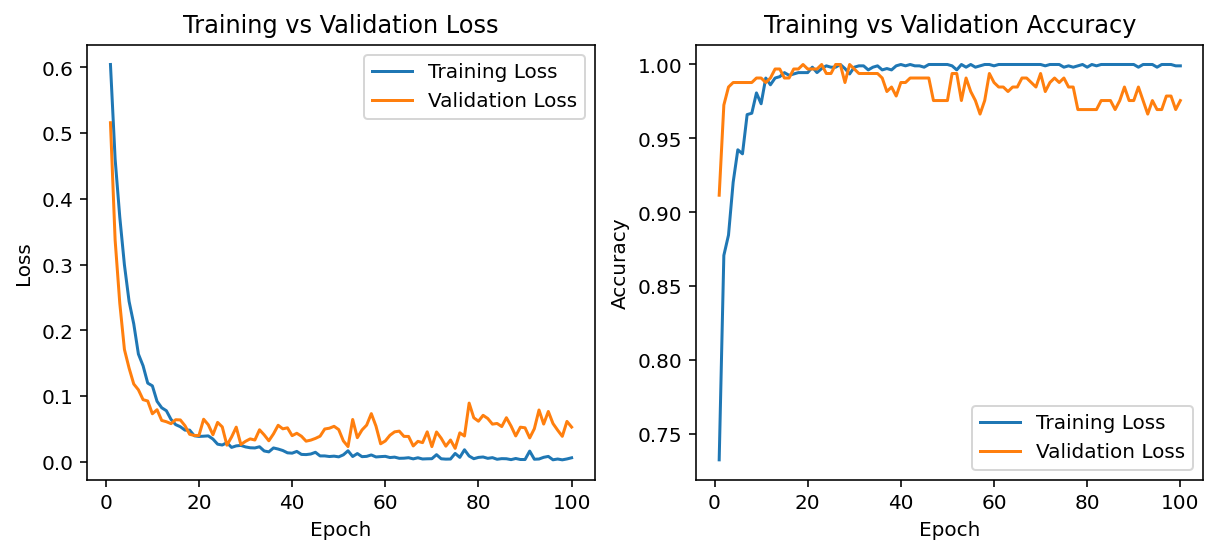

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Training Loss')
axs[0].plot(list(range(1, len(val_loss)+1)), val_loss, label='Validation Loss')
axs[0].set_title('Training vs Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(list(range(1,len(train_acc)+1)), train_acc, label='Training Loss')
axs[1].plot(list(range(1, len(val_acc)+1)), val_acc, label='Validation Loss')
axs[1].set_title('Training vs Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.show()

In [ ]:
model_name = 'googlenet'
num_classes = 2

googlenet_mode = 'fine_tuning'

googlenet, input_size = initialize_model(model_name, num_classes, googlenet_mode, use_pretrained=True)

googlenet_params = []
for name, param in googlenet.named_parameters():
    if param.requires_grad == True:
        googlenet_params.append(param)

googlenet_batch_size = 32
googlenet_num_epochs = 30

googlenet_criterion = nn.CrossEntropyLoss()

googlenet_learning_rate = 0.00001
googlenet_weight_decay = 0
googlenet_optimizer = optim.Adam(googlenet_params, lr=googlenet_learning_rate, weight_decay=googlenet_weight_decay)

googlenet_gamma = 1
googlenet_step_size = 10
googlenet_scheduler = lr_scheduler.StepLR(googlenet_optimizer, step_size=googlenet_step_size, gamma=googlenet_gamma)

Fine tuning: training all the layers


## 4.3. Model selection
Once found the best hyperparameters for each model, we can compare their performance on an independent test set. To this end, we train each model on the union of training and validation data, with the hyperparameters found in the previous stage, and evaluate his performance on the test data. The model that gains the best performance on the test set will be choose for the submission.

### 4.3.1. AlexNet

In [94]:
model_name = 'alexnet'
num_classes = 2

alexnet_mode = 'feature_extraction'

alexnet, input_size = initialize_model(model_name, num_classes, alexnet_mode, use_pretrained=True)

alexnet_params = []
for name, param in alexnet.named_parameters():
    if param.requires_grad == True:
        alexnet_params.append(param)

alexnet_batch_size = 32
alexnet_num_epochs = 30

alexnet_criterion = nn.CrossEntropyLoss()

alexnet_learning_rate = 0.00001
alexnet_weight_decay = 0
alexnet_optimizer = optim.Adam(alexnet_params, lr=alexnet_learning_rate, weight_decay=alexnet_weight_decay)

alexnet_gamma = 1
alexnet_step_size = 10
alexnet_scheduler = lr_scheduler.StepLR(alexnet_optimizer, step_size=alexnet_step_size, gamma=alexnet_gamma)

Feature extraction: training classifier


In [95]:
print(alexnet)
print()
print("Params to learn:")
for name, param in alexnet.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [96]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.RandomRotation(90),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ])
                   }

data_dir = '/content/dataset/modelselect'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=alexnet_batch_size, shuffle=True, num_workers=4) for x in ['train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1420}
['egg', 'empty']


In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

alexnet = alexnet.to(device)

cuda:0


Train the model with the best hyperparameters on the union of training and validation set.

In [98]:
alexnet, train_loss, train_acc = train_model(alexnet, dataloaders, alexnet_criterion, alexnet_optimizer, alexnet_scheduler, alexnet_num_epochs)

Epoch 0/29
----------
train Loss: 0.5336 Acc: 0.7296

Epoch 1/29
----------
train Loss: 0.3644 Acc: 0.8514

Epoch 2/29
----------
train Loss: 0.2967 Acc: 0.8887

Epoch 3/29
----------
train Loss: 0.2685 Acc: 0.8937

Epoch 4/29
----------
train Loss: 0.2498 Acc: 0.8993

Epoch 5/29
----------
train Loss: 0.2310 Acc: 0.9141

Epoch 6/29
----------
train Loss: 0.2320 Acc: 0.9070

Epoch 7/29
----------
train Loss: 0.2150 Acc: 0.9162

Epoch 8/29
----------
train Loss: 0.2158 Acc: 0.9141

Epoch 9/29
----------
train Loss: 0.2104 Acc: 0.9218

Epoch 10/29
----------
train Loss: 0.2073 Acc: 0.9197

Epoch 11/29
----------
train Loss: 0.1957 Acc: 0.9190

Epoch 12/29
----------
train Loss: 0.2019 Acc: 0.9183

Epoch 13/29
----------
train Loss: 0.1854 Acc: 0.9310

Epoch 14/29
----------
train Loss: 0.1780 Acc: 0.9289

Epoch 15/29
----------
train Loss: 0.1787 Acc: 0.9324

Epoch 16/29
----------
train Loss: 0.1690 Acc: 0.9338

Epoch 17/29
----------
train Loss: 0.1816 Acc: 0.9239

Epoch 18/29
--------

Predict the class of the test's images.

In [99]:
alexnet.eval()

df_res = pd.DataFrame(columns=['path', 'acquisition', 'name', 'direction', 'label', 'predicted'])

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                      ])

for index, row in df_test.iterrows():
  input = row.path
  print('Working on '+ input)

  img = Image.open(input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = alexnet(img)
  _, predicted = torch.max(outputs, 1)

  res = row.copy()
  res['predicted'] = class_names[predicted.item()]

  df_res = df_res.append(res)

Working on /content/dataset/train/empty/Acquisizione6_micro_07_10_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_05_00_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_04_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_15_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_08_05_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_12_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_06_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_12_09_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_10_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_13_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_0

Evaluate model's performance on test set.

In [100]:
true_label = df_res.label.values
predicted = df_res.predicted.values

print((np.sum((true_label == predicted).astype(int)))/df_res.shape[0])

0.8079470198675497


In [101]:
confusion_matrix(true_label, predicted)

array([[ 91,  49],
       [  9, 153]])

### 4.3.2. VGG11

In [ ]:
model_name = 'vgg11'
num_classes = 2

vgg11_mode = 'mixed'

vgg11, input_size = initialize_model(model_name, num_classes, vgg11_mode, use_pretrained=True)

vgg11_params = []
for name, param in vgg11.named_parameters():
    if param.requires_grad == True:
        vgg11_params.append(param)

vgg11_batch_size = 32
vgg11_num_epochs = 30

vgg11_criterion = nn.CrossEntropyLoss()

vgg11_learning_rate = 0.00001
vgg11_weight_decay = 0
vgg11_optimizer = optim.Adam(vgg11_params, lr=vgg11_learning_rate, weight_decay=vgg11_weight_decay)

vgg11_gamma = 1
vgg11_step_size = 10
vgg11_scheduler = lr_scheduler.StepLR(vgg11_optimizer, step_size=vgg11_step_size, gamma=vgg11_gamma)

Mixed: training classifier and last convolutional layer


In [65]:
print(vgg11)
print()
print("Params to learn:")
for name, param in vgg11.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [66]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ])
                   }

data_dir = '/content/dataset/modelselect'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=vgg11_batch_size, shuffle=True, num_workers=4) for x in ['train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1420}
['egg', 'empty']


In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

vgg11 = vgg11.to(device)

cuda:0


In [68]:
vgg11, train_loss, train_acc = train_model(vgg11, dataloaders, vgg11_criterion, vgg11_optimizer, vgg11_scheduler, vgg11_num_epochs)

Epoch 0/29
----------
train Loss: 0.5200 Acc: 0.7775

Epoch 1/29
----------
train Loss: 0.2624 Acc: 0.9134

Epoch 2/29
----------
train Loss: 0.1858 Acc: 0.9275

Epoch 3/29
----------
train Loss: 0.1360 Acc: 0.9507

Epoch 4/29
----------
train Loss: 0.0998 Acc: 0.9676

Epoch 5/29
----------
train Loss: 0.0676 Acc: 0.9852

Epoch 6/29
----------
train Loss: 0.0577 Acc: 0.9817

Epoch 7/29
----------
train Loss: 0.0588 Acc: 0.9824

Epoch 8/29
----------
train Loss: 0.0354 Acc: 0.9923

Epoch 9/29
----------
train Loss: 0.0309 Acc: 0.9937

Epoch 10/29
----------
train Loss: 0.0290 Acc: 0.9915

Epoch 11/29
----------
train Loss: 0.0297 Acc: 0.9937

Epoch 12/29
----------
train Loss: 0.0173 Acc: 0.9965

Epoch 13/29
----------
train Loss: 0.0145 Acc: 0.9972

Epoch 14/29
----------
train Loss: 0.0111 Acc: 0.9979

Epoch 15/29
----------
train Loss: 0.0094 Acc: 0.9986

Epoch 16/29
----------
train Loss: 0.0087 Acc: 0.9993

Epoch 17/29
----------
train Loss: 0.0076 Acc: 1.0000

Epoch 18/29
--------

In [69]:
vgg11.eval()

df_res = pd.DataFrame(columns=['path', 'acquisition', 'name', 'direction', 'label', 'predicted'])

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                      ])

for index, row in df_test.iterrows():
  input = row.path
  print('Working on '+ input)

  img = Image.open(input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = vgg11(img)
  _, predicted = torch.max(outputs, 1)

  res = row.copy()
  res['predicted'] = class_names[predicted.item()]

  df_res = df_res.append(res)

Working on /content/dataset/train/empty/Acquisizione6_micro_07_10_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_05_00_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_04_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_15_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_08_05_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_12_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_06_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_12_09_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_10_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_13_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_0

In [70]:
true_label = df_res.label.values
predicted = df_res.predicted.values

print((np.sum((true_label == predicted).astype(int)))/df_res.shape[0])

0.9635761589403974


In [71]:
confusion_matrix(true_label, predicted)

array([[132,   8],
       [  3, 159]])

### 4.3.3. GoogLeNet

In [79]:
model_name = 'googlenet'
num_classes = 2

googlenet_mode = 'fine_tuning'

googlenet, input_size = initialize_model(model_name, num_classes, googlenet_mode, use_pretrained=True)

googlenet_params = []
for name, param in googlenet.named_parameters():
    if param.requires_grad == True:
        googlenet_params.append(param)

googlenet_batch_size = 32
googlenet_num_epochs = 30

googlenet_criterion = nn.CrossEntropyLoss()

googlenet_learning_rate = 0.00001
googlenet_weight_decay = 0
googlenet_optimizer = optim.Adam(googlenet_params, lr=googlenet_learning_rate, weight_decay=googlenet_weight_decay)

googlenet_gamma = 1
googlenet_step_size = 10
googlenet_scheduler = lr_scheduler.StepLR(googlenet_optimizer, step_size=googlenet_step_size, gamma=googlenet_gamma)

Fine tuning: training all the layers


In [80]:
print(googlenet)
print()
print("Params to learn:")
for name, param in googlenet.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [81]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ])
                   }

data_dir = '/content/dataset/modelselect'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=googlenet_batch_size, shuffle=True, num_workers=4) for x in ['train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1420}
['egg', 'empty']


In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

googlenet = googlenet.to(device)

cuda:0


In [83]:
googlenet, train_loss, train_acc = train_model(googlenet, dataloaders, googlenet_criterion, googlenet_optimizer, googlenet_scheduler, googlenet_num_epochs)

Epoch 0/29
----------
train Loss: 0.5893 Acc: 0.7275

Epoch 1/29
----------
train Loss: 0.4139 Acc: 0.8789

Epoch 2/29
----------
train Loss: 0.3002 Acc: 0.9155

Epoch 3/29
----------
train Loss: 0.2365 Acc: 0.9303

Epoch 4/29
----------
train Loss: 0.1977 Acc: 0.9479

Epoch 5/29
----------
train Loss: 0.1571 Acc: 0.9556

Epoch 6/29
----------
train Loss: 0.1271 Acc: 0.9761

Epoch 7/29
----------
train Loss: 0.1041 Acc: 0.9796

Epoch 8/29
----------
train Loss: 0.0897 Acc: 0.9831

Epoch 9/29
----------
train Loss: 0.0750 Acc: 0.9880

Epoch 10/29
----------
train Loss: 0.0749 Acc: 0.9866

Epoch 11/29
----------
train Loss: 0.0615 Acc: 0.9908

Epoch 12/29
----------
train Loss: 0.0469 Acc: 0.9937

Epoch 13/29
----------
train Loss: 0.0503 Acc: 0.9937

Epoch 14/29
----------
train Loss: 0.0512 Acc: 0.9908

Epoch 15/29
----------
train Loss: 0.0401 Acc: 0.9937

Epoch 16/29
----------
train Loss: 0.0282 Acc: 0.9979

Epoch 17/29
----------
train Loss: 0.0292 Acc: 0.9972

Epoch 18/29
--------

In [84]:
googlenet.eval()

df_res = pd.DataFrame(columns=['path', 'acquisition', 'name', 'direction', 'label', 'predicted'])

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                      ])

for index, row in df_test.iterrows():
  input = row.path
  print('Working on '+ input)

  img = Image.open(input)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = googlenet(img)
  _, predicted = torch.max(outputs, 1)

  res = row.copy()
  res['predicted'] = class_names[predicted.item()]

  df_res = df_res.append(res)

Working on /content/dataset/train/empty/Acquisizione6_micro_07_10_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_05_00_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_04_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_15_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_08_05_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_07_12_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_06_08_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_12_09_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_10_03_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_13_07_central.png
Working on /content/dataset/train/empty/Acquisizione6_micro_00_0

In [85]:
true_label = df_res.label.values
predicted = df_res.predicted.values

print((np.sum((true_label == predicted).astype(int)))/df_res.shape[0])

0.9503311258278145


In [86]:
confusion_matrix(true_label, predicted)

array([[127,  13],
       [  2, 160]])

# 5. Submission
The best network is VGG11 (with batch normalization), so we choose it as final model.

Now we can finally create the submission file. To to so, we first train the final model using the whole training set, then we predict the class label for the instances of the (original) test set.

In [102]:
model_name = 'vgg11'
num_classes = 2

vgg11_mode = 'mixed'

final_vgg11, input_size = initialize_model(model_name, num_classes, vgg11_mode, use_pretrained=True)

vgg11_params = []
for name, param in final_vgg11.named_parameters():
    if param.requires_grad == True:
        vgg11_params.append(param)

vgg11_batch_size = 32
vgg11_num_epochs = 30

vgg11_criterion = nn.CrossEntropyLoss()

vgg11_learning_rate = 0.00001
vgg11_weight_decay = 0
vgg11_optimizer = optim.Adam(vgg11_params, lr=vgg11_learning_rate, weight_decay=vgg11_weight_decay)

vgg11_gamma = 1
vgg11_step_size = 10
vgg11_scheduler = lr_scheduler.StepLR(vgg11_optimizer, step_size=vgg11_step_size, gamma=vgg11_gamma)

Mixed: training classifier and last convolutional layer


In [103]:
print(final_vgg11)
print()
print("Params to learn:")
for name, param in final_vgg11.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [104]:
data_transforms = {'train':transforms.Compose([transforms.Resize(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.RandomVerticalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                                    [0.229, 0.224, 0.225])
                                               ])
                   }

data_dir = '/content/dataset'

image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=vgg11_batch_size, shuffle=True, num_workers=4) for x in ['train']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes
print(dataset_sizes)
print(class_names)

{'train': 1722}
['empty', 'uovo']


In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

final_vgg11 = final_vgg11.to(device)

cuda:0


Train the model using the whole training set.

In [106]:
final_vgg11, train_loss, train_acc = train_model(final_vgg11, dataloaders, vgg11_criterion, vgg11_optimizer, vgg11_scheduler, vgg11_num_epochs)

Epoch 0/29
----------
train Loss: 0.4791 Acc: 0.8206

Epoch 1/29
----------
train Loss: 0.2461 Acc: 0.9123

Epoch 2/29
----------
train Loss: 0.1764 Acc: 0.9332

Epoch 3/29
----------
train Loss: 0.1115 Acc: 0.9640

Epoch 4/29
----------
train Loss: 0.0941 Acc: 0.9750

Epoch 5/29
----------
train Loss: 0.0639 Acc: 0.9849

Epoch 6/29
----------
train Loss: 0.0504 Acc: 0.9878

Epoch 7/29
----------
train Loss: 0.0321 Acc: 0.9930

Epoch 8/29
----------
train Loss: 0.0286 Acc: 0.9942

Epoch 9/29
----------
train Loss: 0.0308 Acc: 0.9895

Epoch 10/29
----------
train Loss: 0.0232 Acc: 0.9942

Epoch 11/29
----------
train Loss: 0.0206 Acc: 0.9942

Epoch 12/29
----------
train Loss: 0.0171 Acc: 0.9959

Epoch 13/29
----------
train Loss: 0.0112 Acc: 0.9983

Epoch 14/29
----------
train Loss: 0.0117 Acc: 0.9971

Epoch 15/29
----------
train Loss: 0.0102 Acc: 0.9977

Epoch 16/29
----------
train Loss: 0.0101 Acc: 0.9977

Epoch 17/29
----------
train Loss: 0.0061 Acc: 0.9988

Epoch 18/29
--------

Save the final model trained

In [112]:
model_path = 'drive/MyDrive/Colab Notebooks/DM - Collab/Mini Contest 3/models/model_vgg11bn.pth'
torch.save(final_vgg11.state_dict(), model_path)

Predict class label of the test images.

In [107]:
final_vgg11.eval()

df_sub = pd.DataFrame(columns=['ID', 'Class'])

data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])
                                      ])

test_dir = '/content/dataset/test/'

for entry in test:
  print('Working on '+ entry)

  img = Image.open(test_dir + entry)
  img = data_transforms(img).to(device)
  img = img.unsqueeze_(0)
  outputs = final_vgg11(img)
  _, predicted = torch.max(outputs, 1)

  id = entry.split('.')[0]
  label = class_names[predicted.item()]
  row = {'ID':[id], 'Class':[label]}

  df_sub = df_sub.append(pd.DataFrame(row))

Working on 4_53.png
Working on 4_317.png
Working on 4_121.png
Working on 4_324.png
Working on 4_6.png
Working on 4_69.png
Working on K_15.png
Working on 4_52.png
Working on 4_36.png
Working on 4_47.png
Working on 4_84.png
Working on K_31.png
Working on 2_16.png
Working on 4_338.png
Working on 4_22.png
Working on 2_332.png
Working on 2_227.png
Working on 4_133.png
Working on 2_123.png
Working on 2_114.png
Working on K_5.png
Working on 4_242.png
Working on 4_32.png
Working on 2_151.png
Working on 2_136.png
Working on 4_51.png
Working on 4_83.png
Working on 4_266.png
Working on 4_191.png
Working on 4_150.png
Working on 2_71.png
Working on 2_169.png
Working on 2_152.png
Working on 4_305.png
Working on 4_101.png
Working on 2_108.png
Working on 4_110.png
Working on 4_49.png
Working on 2_106.png
Working on 2_263.png
Working on 4_337.png
Working on 2_149.png
Working on 2_234.png
Working on 2_134.png
Working on 2_141.png
Working on 2_44.png
Working on K_40.png
Working on 2_256.png
Working on 4_

We can look at the class distribution of the test instances.

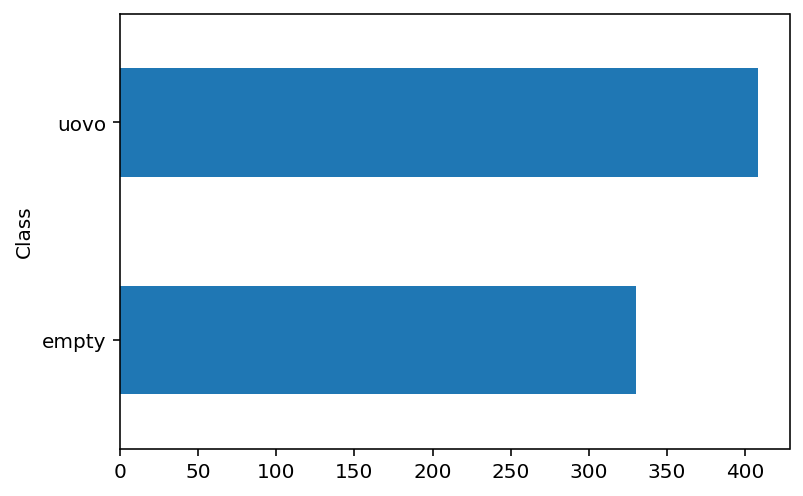

In [108]:
df_sub.groupby('Class').ID.count().plot.barh()
plt.show()

In [109]:
sub_path = 'drive/MyDrive/Colab Notebooks/DM - Collab/Mini Contest 3/submission/sub_vgg11bn.csv'
df_sub.to_csv(sub_path, index=False)